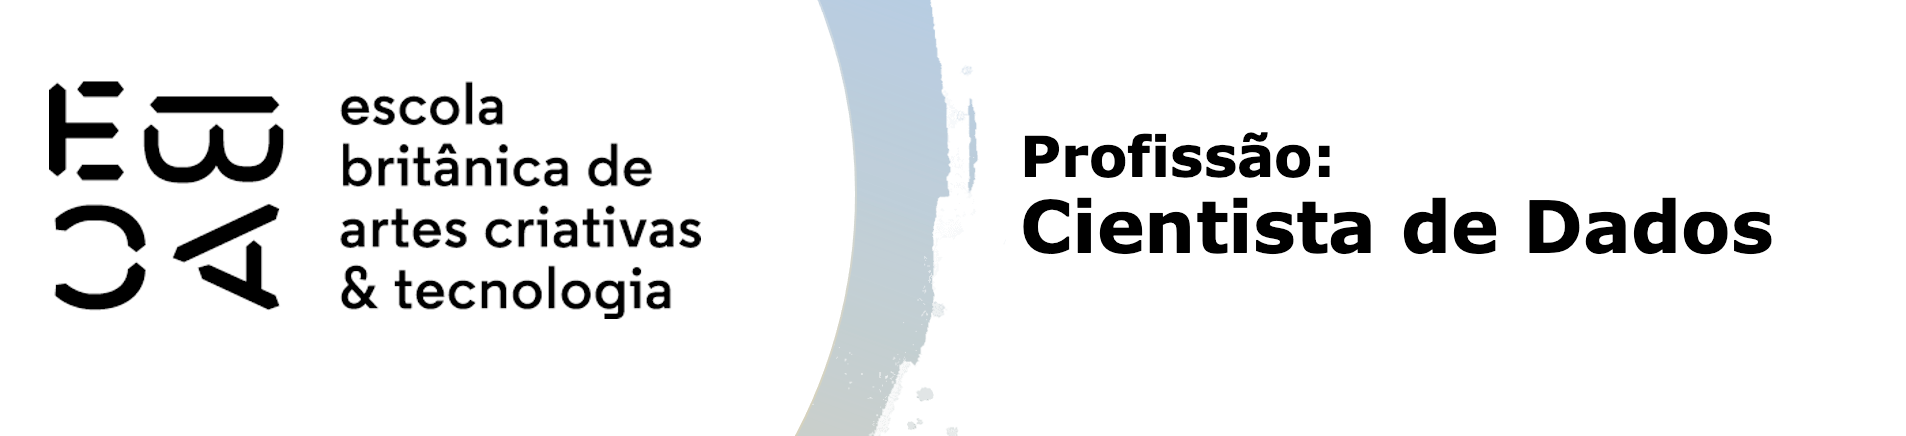

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import patsy
import numpy as np
from pycaret.classification import *

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


Para evitar conflito com algum frame-work, convertemos os booleanos da variável reposta para int...

In [3]:
df['mau'] = df['mau'].astype(int)

Devido ao exarcerbado tamanho da base de dados, convém utilizar uma amostra do dataframe. Usaremos um sample de 20% da base total.

In [4]:
df_sample = df.sample(frac=0.2, random_state=40028922)
df_sample_pipe = df_sample.copy()
#df_sample = df.copy() ## SE der merda, apagar esta linha. Aqui, estamos usando 100% da base de dados.

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.

In [5]:
df['data_ref'].value_counts()

df_outoftime = df_sample[df_sample['data_ref']>='2016-01-01']
df_outoftime_pipe = df_outoftime.copy()
df_sample_treino = df_sample[df_sample['data_ref']<'2016-01-01'].copy()
df_sample_treino_pipe = df_sample.copy()

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [6]:
linhas_describe = ['Overall', df_sample.shape[0]]
colunas_describe = ['Número de dados']
df_sample['mês'] = df_sample['data_ref'].dt.to_period('M')
a = df_sample['mês'].value_counts()
a = pd.concat([pd.Series(df_sample.shape[0], index=['Overall']), a])
df_sample_describe = pd.DataFrame(a , columns=colunas_describe)
df_sample_describe = pd.concat([df_sample_describe[:1], df_sample_describe[1:].sort_index()])
df_sample_describe

,Número de dados
Overall,150000
2015-01,9905
2015-02,10048
2015-03,9932
2015-04,10147
2015-05,9998
2015-06,10041
2015-07,10012
2015-08,10099
2015-09,9944


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

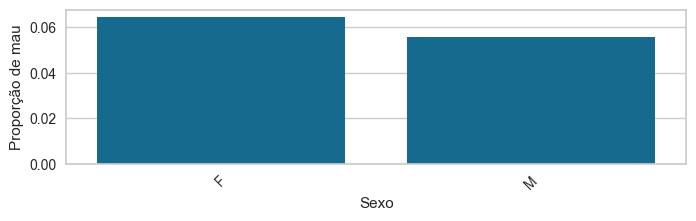

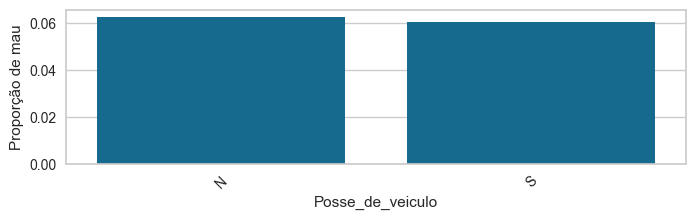

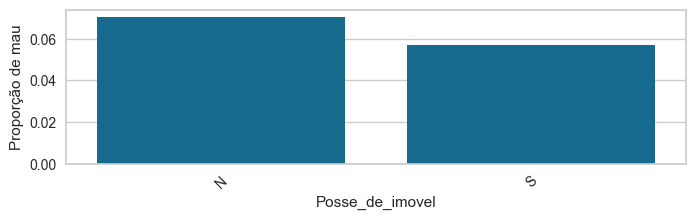

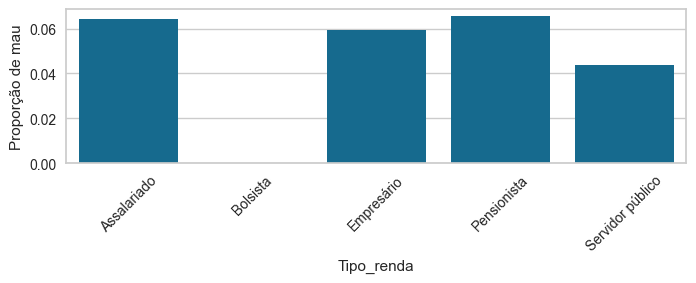

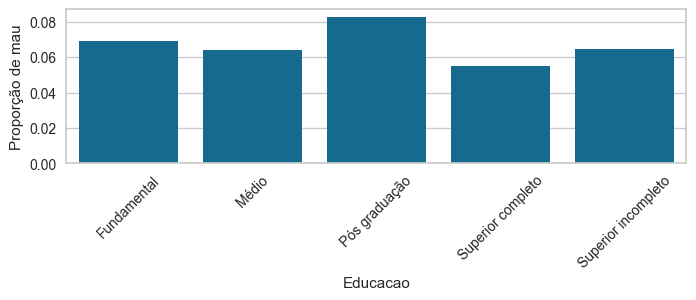

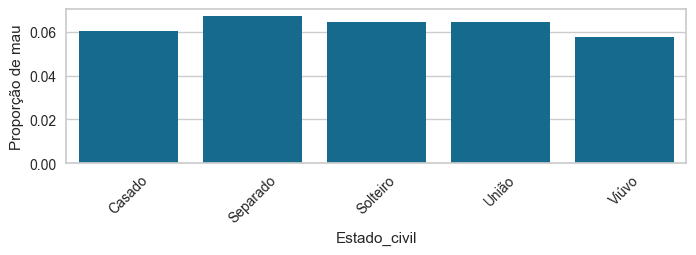

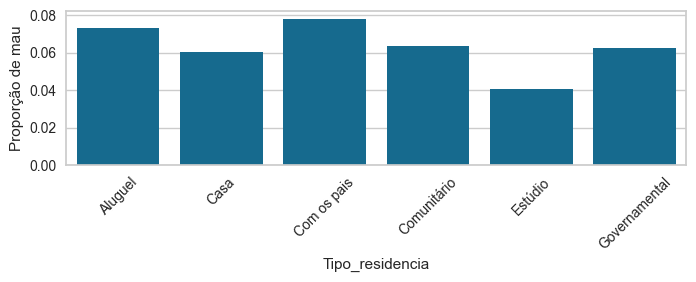

In [7]:
cat_vars = df_sample.columns.drop(['data_ref', 'index', 'qtd_filhos', 'idade', 'tempo_emprego', 
                                   'qt_pessoas_residencia', 'renda', 'mau', 'mês'])
num_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

for v in cat_vars:
    proporcao = df_sample_treino.groupby(v)['mau'].mean().to_frame().reset_index()
    plt.figure(figsize=(8,2))
    sns.barplot(x=v, y='mau', data=proporcao)
    plt.xticks(rotation=45)
    plt.ylabel('Proporção de mau')
    plt.xlabel(f'{v.capitalize()}')
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [8]:
# Nossa única coluna que possui missings é tempo_emprego, onde, certamente, o missing deve significar que a pessoa não tem emprego (logo, não tem tempo
# de emprego). Portanto, vamos criar uma dummy pra sinalizar essa situação, e trocar por 0 o tempo de emprego, porquanto a ausência de um emprego 
# também pode ser importante para o nosso modelo. Assim:

df_sample_treino['tem_emprego'] = df_sample_treino['tempo_emprego'].notnull()
df_sample_treino.loc[df_sample_treino['tempo_emprego'].isnull(), 'tempo_emprego'] = 0

#Agora, vamos selecionar as variáveis do modelo...
variaveis_1 = 'mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + np.log(renda) + tem_emprego'

#Debug
variaveis_1 = 'mau ~  + tem_emprego + sexo + qtd_filhos + posse_de_veiculo + posse_de_imovel + idade + tempo_emprego + np.log(renda) + tipo_residencia + qt_pessoas_residencia + estado_civil + educacao'

y, X = patsy.dmatrices(variaveis_1, data=df_sample_treino, return_type='dataframe')
modelo1 = sm.Logit(y, X).fit()
modelo1.summary()

Optimization terminated successfully.
         Current function value: 0.201857
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               119908
Model:                          Logit   Df Residuals:                   119885
Method:                           MLE   Df Model:                           22
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                  0.1273
Time:                        18:36:35   Log-Likelihood:                -24204.
converged:                       True   LL-Null:                       -27734.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            5.9363      0.432     13.731      0.000       5.089       6.784
tem_emprego[T.True]                 -0.0215      0.049     -0.435      0.664      -0.118       0.075
sexo[T.M]                           -0.0575      0.030     -1.914      0.056      -0.116       0.001
posse_de_veiculo[T.S]                0.0169      0.028      0.599      0.549      -0.038       0.072
posse_de_imovel[T.S]                -0.0456      0.027     -1.696      0.090      -0.098       0.007
tipo_residencia[T.Casa]             -0.0060      0.101     -0.059      0.953      -0.205       0.193
tipo_residencia[T.Com os pais]       0.0632      0.114      0.556      0.578      -0.160       0.286
tipo_residencia[T.Comunitário]      -0.1440      0.213     -0.676      0.499      -0.561       0.273
tipo_residencia[T.Estúdio]          -0.2660      0.207     -1.286      0.198      -0.671       0.139
tipo_residencia[T.Governamental]     0.0042      0.123      0.034      0.973      -0.237       0.245
estado_civil[T.Separado]             0.0002      0.197      0.001      0.999      -0.385       0.386
estado_civil[T.Solteiro]            -0.0246      0.193     -0.128      0.898      -0.402       0.353
estado_civil[T.União]                0.0036      0.047      0.076      0.939      -0.088       0.095
estado_civil[T.Viúvo]               -0.1124      0.201     -0.559      0.576      -0.507       0.282
educacao[T.Médio]                    0.0192      0.111      0.173      0.863      -0.199       0.237
educacao[T.Pós graduação]            0.1941      0.345      0.563      0.573      -0.482       0.870
educacao[T.Superior completo]       -0.0110      0.113     -0.097      0.923      -0.233       0.211
educacao[T.Superior incompleto]     -0.0040      0.127     -0.032      0.975      -0.253       0.245
qtd_filhos                           0.0638      0.190      0.336      0.737      -0.308       0.436
idade                                0.0005      0.002      0.312      0.755      -0.003       0.004
tempo_emprego                        0.0010      0.004      0.256      0.798      -0.007       0.009
np.log(renda)                       -0.9795      0.015    -66.393      0.000      -1.008      -0.951
qt_pessoas_residencia               -0.0412      0.190     -0.217      0.828      -0.413       0.330
====================================================================================================
"""

Algumas variáveis não são significativas em nenhuma de suas dummies, logo podem ser retiradas do modelo, isto é: tipo_residencia, educacao, qtd_filhos, idade e qt_pessoas_residencia.

In [9]:
variaveis_2 = 'mau ~  + tem_emprego + sexo + posse_de_veiculo + posse_de_imovel + tempo_emprego + renda + estado_civil'

y, X = patsy.dmatrices(variaveis_2, data=df_sample_treino, return_type='dataframe')
modelo3 = sm.Logit(y, X).fit()
modelo3.summary()


## Avaliação do modelo

Optimization terminated successfully.
         Current function value: 0.209825
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               119908
Model:                          Logit   Df Residuals:                   119897
Method:                           MLE   Df Model:                           10
Date:                Sun, 07 Dec 2025   Pseudo R-squ.:                 0.09282
Time:                        18:36:37   Log-Likelihood:                -25160.
converged:                       True   LL-Null:                       -27734.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.6840      0.040    -42.439      0.000      -1.762      -1.606
tem_emprego[T.True]          0.1859      0.038      4.837      0.000       0.111       0.261
sexo[T.M]                   -0.1698      0.029     -5.824      0.000      -0.227      -0.113
posse_de_veiculo[T.S]        0.0119      0.027      0.433      0.665      -0.042       0.065
posse_de_imovel[T.S]        -0.1173      0.026     -4.584      0.000      -0.168      -0.067
estado_civil[T.Separado]     0.0747      0.052      1.451      0.147      -0.026       0.176
estado_civil[T.Solteiro]     0.0011      0.037      0.030      0.976      -0.072       0.075
estado_civil[T.União]       -0.0081      0.046     -0.178      0.859      -0.098       0.081
estado_civil[T.Viúvo]       -0.0900      0.065     -1.376      0.169      -0.218       0.038
tempo_emprego               -0.0210      0.004     -5.316      0.000      -0.029      -0.013
renda                    -9.888e-05   2.37e-06    -41.799      0.000      -0.000   -9.42e-05
============================================================================================
"""

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [10]:
df_teste = df_outoftime[['mau', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'estado_civil', 'tempo_emprego', 'renda']].copy()
df_teste['tem_emprego'] = df_teste['tempo_emprego'].notnull().copy()
df_teste.loc[df_teste['tempo_emprego'].isnull(), 'tempo_emprego'] = 0


['tem_emprego[T.True]', 'sexo[T.M]',
       'posse_de_veiculo[T.S]', 'posse_de_imovel[T.S]',
       'estado_civil[T.Separado]', 'estado_civil[T.Solteiro]',
       'estado_civil[T.União]', 'estado_civil[T.Viúvo]', 'tempo_emprego',
       'renda']

y_pred_prob = modelo1.predict()

y_test, x_test = patsy.dmatrices(variaveis_2, df_teste, return_type='dataframe')

y_prob = modelo3.predict(x_test)

y_pred = (y_prob<=0.1).astype(int)

print(f'A acurácia foi de {accuracy_score(y_test, y_pred)}')

print('Acurácia:', accuracy_score(y_test, y_pred))
print('Precisão:', precision_score(y_test, y_pred))
print('Revocação:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))
print('AUC:', roc_auc_score(y_test, y_prob))
print('Matriz de confusão:\n', confusion_matrix(y_test, y_pred))


A acurácia foi de 0.5084407816030839
Acurácia: 0.5084407816030839
Precisão: 0.04983359607637064
Revocação: 0.1261081560283688
F1: 0.0714375392341494
AUC: 0.7268599129625317
Matriz de confusão:
 [[14731 10849]
 [ 3943   569]]


Deixo aqui um comentário a respeito da precisão baixa do modelo, para o corretor, a fim de vrificar se existe uma causa para tal "fenômeno"

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [11]:
from pycaret.classification import *

df_sample.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mês
605094,2016-01-01,14082,F,N,N,0,Empresário,Médio,Casado,Casa,54,1.789041,2.0,705.65,0,2016-01
484297,2015-10-01,2139,F,N,S,0,Empresário,Superior completo,Casado,Casa,62,37.531507,2.0,699330.77,0,2015-10
174121,2015-04-01,4500,F,S,N,0,Empresário,Superior completo,Casado,Casa,53,4.597260,2.0,15772.49,0,2015-04
299412,2015-06-01,6042,F,N,S,0,Empresário,Médio,Casado,Casa,55,7.389041,2.0,26363.01,0,2015-06
358305,2015-08-01,10546,F,N,S,0,Empresário,Médio,União,Casa,35,1.838356,2.0,38353.04,0,2015-08


In [12]:
df_sample_pipe.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
605094,2016-01-01,14082,F,N,N,0,Empresário,Médio,Casado,Casa,54,1.789041,2.0,705.65,0
484297,2015-10-01,2139,F,N,S,0,Empresário,Superior completo,Casado,Casa,62,37.531507,2.0,699330.77,0
174121,2015-04-01,4500,F,S,N,0,Empresário,Superior completo,Casado,Casa,53,4.597260,2.0,15772.49,0
299412,2015-06-01,6042,F,N,S,0,Empresário,Médio,Casado,Casa,55,7.389041,2.0,26363.01,0
358305,2015-08-01,10546,F,N,S,0,Empresário,Médio,União,Casa,35,1.838356,2.0,38353.04,0


In [13]:
df_sample=df_sample.drop(columns = ['mês'])
teste_pycaret = setup(data = df_sample_pipe, target = 'mau', session_id=123, experiment_name='Regressão Logistica - Pycaret', normalize=True, normalize_method='zscore', transformation=True, transformation_method='quantile', fix_imbalance=True)

  File "C:\Users\Matheus\anaconda3\envs\pycaret_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Matheus\anaconda3\envs\pycaret_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Matheus\anaconda3\envs\pycaret_env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Matheus\anaconda3\envs\pycaret_env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(150000, 15)"
4,Transformed data shape,"(238346, 34)"
5,Transformed train set shape,"(193346, 34)"
6,Transformed test set shape,"(45000, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [14]:
best_model = compare_models(fold=4, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9168,0.7756,0.0980,0.3996,0.1573,0.1302,0.1669,2.0625
gbc,Gradient Boosting Classifier,0.9148,0.7748,0.1215,0.3835,0.1846,0.1522,0.1807,17.5975
ada,Ada Boost Classifier,0.9056,0.7586,0.1841,0.3299,0.2358,0.1899,0.1993,5.1325
lr,Logistic Regression,0.8995,0.7574,0.2039,0.3021,0.2435,0.1918,0.1961,3.1375
svm,SVM - Linear Kernel,0.9012,0.7420,0.1650,0.2888,0.2067,0.1588,0.1673,1.0225
ridge,Ridge Classifier,0.8874,0.7285,0.2282,0.2604,0.2432,0.1826,0.1831,0.8975
lda,Linear Discriminant Analysis,0.8875,0.7284,0.2278,0.2606,0.2431,0.1826,0.1831,1.1200
rf,Random Forest Classifier,0.9005,0.7100,0.0978,0.2175,0.1348,0.0900,0.0982,6.6200
nb,Naive Bayes,0.1001,0.6623,0.9938,0.0806,0.1491,0.0027,0.0312,2.1650
et,Extra Trees Classifier,0.8956,0.6460,0.1042,0.1987,0.1367,0.0868,0.0920,6.3875


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

A técnica de Seleção de variáveis será a Feature Importance

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [16]:
#df_sample_pipe = pd.get_dummies(df_sample_pipe, columns=['posse_de_veiculo'])
#print(df_sample_pipe.head())
teste_pycaret = setup(data = df_sample_pipe, target = 'mau', session_id=123, experiment_name='Regressão Logistica - Pycaret', 
                      normalize=True, normalize_method='zscore', transformation=True, transformation_method='quantile', fix_imbalance=True,
                      numeric_imputation="mean", remove_outliers=True, pca=True, pca_components=12)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(150000, 15)"
4,Transformed data shape,"(228758, 13)"
5,Transformed train set shape,"(183758, 13)"
6,Transformed test set shape,"(45000, 13)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [17]:
best_model = compare_models(fold=4, sort="AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6715,0.7320,0.6643,0.1486,0.2429,0.1301,0.1901,1.6900
ridge,Ridge Classifier,0.6710,0.7313,0.6637,0.1483,0.2424,0.1295,0.1894,1.7325
lr,Logistic Regression,0.6726,0.7304,0.6649,0.1491,0.2436,0.1310,0.1911,1.6675
svm,SVM - Linear Kernel,0.6597,0.7252,0.6691,0.1446,0.2378,0.1234,0.1839,1.8350
lightgbm,Light Gradient Boosting Machine,0.8740,0.7117,0.2207,0.2144,0.2175,0.1490,0.1490,2.3000
gbc,Gradient Boosting Classifier,0.7915,0.7041,0.4252,0.1715,0.2444,0.1481,0.1688,28.5100
rf,Random Forest Classifier,0.8817,0.6841,0.1522,0.1913,0.1695,0.1067,0.1075,10.9500
ada,Ada Boost Classifier,0.7495,0.6730,0.4388,0.1445,0.2174,0.1114,0.1359,7.2025
qda,Quadratic Discriminant Analysis,0.6775,0.6546,0.5380,0.1299,0.2093,0.0934,0.1309,1.8125
nb,Naive Bayes,0.6647,0.6332,0.5127,0.1205,0.1952,0.0766,0.1088,1.5900


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 15)"
4,Transformed data shape,"(1144910, 13)"
5,Transformed train set shape,"(919910, 13)"
6,Transformed test set shape,"(225000, 13)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8556,0.7188,0.2758,0.1973,0.2300,0.1528,0.1554
1,0.8610,0.7309,0.3086,0.2213,0.2578,0.1834,0.1865
2,0.8583,0.7249,0.2906,0.2085,0.2428,0.1670,0.1698
3,0.8606,0.7287,0.2870,0.2115,0.2435,0.1687,0.1711
4,0.8612,0.7293,0.2952,0.2163,0.2497,0.1752,0.1778
5,0.8586,0.7215,0.2831,0.2059,0.2384,0.1626,0.1651
6,0.8535,0.7279,0.3084,0.2069,0.2477,0.1700,0.1742
7,0.8584,0.7222,0.2911,0.2090,0.2433,0.1676,0.1704
8,0.8620,0.7265,0.2991,0.2194,0.2531,0.1791,0.1817


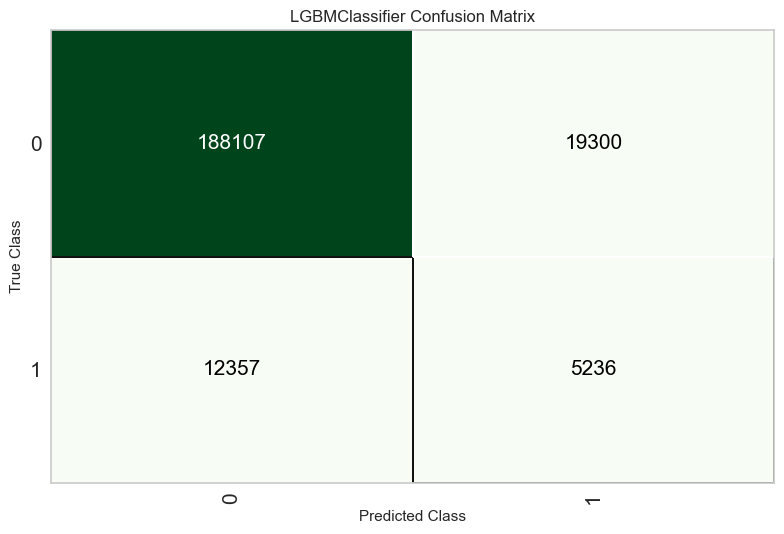

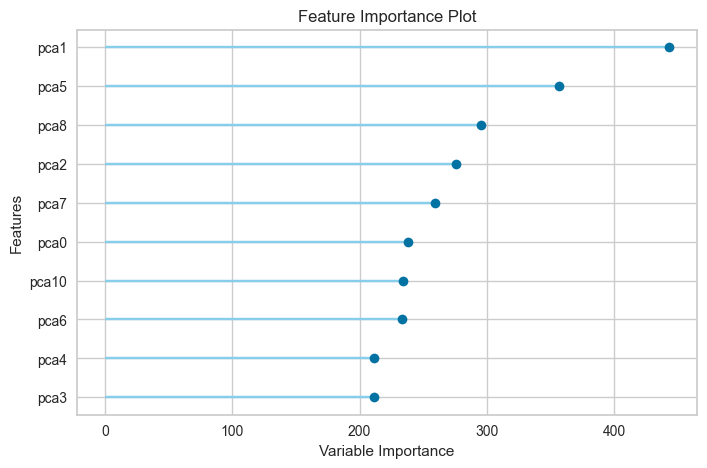

In [18]:
s = setup(
    data = df, target = 'mau', session_id=123, experiment_name='Regressão Logistica - Pycaret', 
                      normalize=True, normalize_method='zscore', transformation=True, transformation_method='quantile', fix_imbalance=True,
                      numeric_imputation="mean", remove_outliers=True, pca=True, pca_components=12
)
modelo = create_model('lightgbm')
plot_model(modelo, plot='confusion_matrix')
plot_model(modelo, plot='feature')

In [19]:
pipeline = get_config('pipeline')

In [20]:
pipeline

Pipeline(memory=FastMemory(location=C:\Users\Matheus\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pe...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True))),
                ('pca',
                 TransformerWrapper(exclude=[], include=None,
                                    transformer=PCA(copy=True,
                                                    iterated_power='auto',
                                                    n_components=12,
                                                    n_oversamples=10,
                                                    power_iteration_normalizer='auto',
                                                    random_state=None,
                                                    svd_solver='auto', tol=0.0,
                                                    whiten=False)))],
         verbose=False)

## Tunando o modelo

In [21]:
tuned = tune_model(modelo)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8766,0.7250,0.2412,0.2275,0.2342,0.1671,0.1672
1,0.8808,0.7422,0.2516,0.2450,0.2483,0.1836,0.1836
2,0.8771,0.7340,0.2509,0.2337,0.2420,0.1752,0.1754
3,0.8790,0.7373,0.2487,0.2380,0.2432,0.1775,0.1776
4,0.8785,0.7374,0.2565,0.2403,0.2481,0.1821,0.1822
5,0.8782,0.7321,0.2487,0.2359,0.2421,0.1760,0.1760
6,0.8773,0.7376,0.2682,0.2425,0.2547,0.1880,0.1883
7,0.8799,0.7313,0.2402,0.2365,0.2383,0.1731,0.1732
8,0.8796,0.7363,0.2512,0.2410,0.2460,0.1806,0.1806


Fitting 10 folds for each of 10 candidates, totalling 100 fits


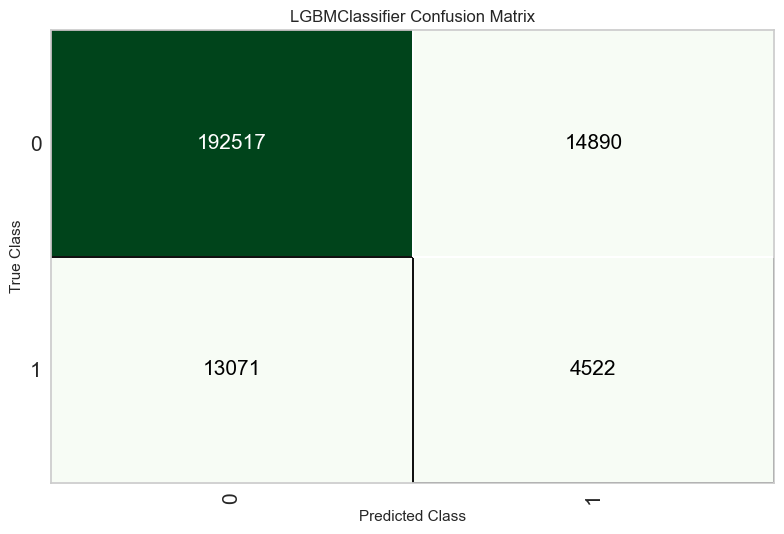

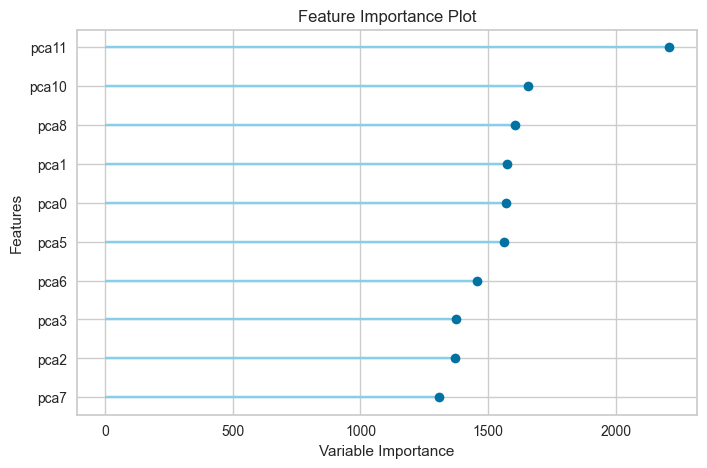

In [22]:
plot_model(tuned, plot = 'confusion_matrix')
plot_model(tuned, plot = 'feature')

In [23]:
save_model(tuned, "Tuned_LightGBM")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                                 boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, feature_fraction=0.4,
                                 importance_typ